## Imports

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from amlbench.benchmark.interface import Benchmark, Method, FeatureSpace
from amlbench.benchmark.benchmark_engine import BenchmarkEngine
from amlbench.benchmark.experiment_reports import get_reports_df
from amlbench.benchmark.split_strategies import LastDaysOfMonthSplit, TimePivotSplit
from amlbench.benchmark.project_folders import create_paths
from amlbench.benchmark.metric import Metric, METRIC_R2, METRIC_CVRMSE
from amlbench.benchmark.results_plots import (
    display_all_plots,
    display_bar_plot,
    display_box_plots,
)
from amlbench.benchmark.method_space import method_space

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LarsCV
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
)
from pathlib import Path
import joblib
import pandas as pd
import numpy as np

# Fixing the random seed
np.random.seed(10)

In [4]:
import sys

sys.path.append("../")  # append parent dir to sys.path

In [5]:
import wind_constants as cst
import main
import feature_engineering as fe

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
plt.rcParams.update(cst.params)
sns.set_style("white")

In [8]:
pd.set_option("max_colwidth", 1500)
pd.set_option("display.width", None)

## Feature Engineering 

In [9]:
data = joblib.load("../data/processed/processed_uncleaned.joblib")

In [10]:
input_data = data[cst.FEATURES].dropna()

In [11]:
extended_data = fe.feature_engineering(dataframe=input_data)

In [12]:
extended_data[cst.TARGET] = data[cst.TARGET]

## Models to benchmark

In [13]:
# In the method object, you can choose to input any model and split_strategy

methods = method_space(
    model=[
        LinearRegression(normalize=True),
        LassoCV(normalize=True),
        RandomForestRegressor(),
        AdaBoostRegressor(),
        LarsCV(normalize=True),
        ExtraTreesRegressor(),
        GradientBoostingRegressor(),
    ],
    split_strategy=[TimePivotSplit(pivot_quantile=0.5)],
)

### Features and Target (for relative production)

In [14]:
extended = FeatureSpace(
    name="extended", features=cst.EXTENDED_FEATURES, methods=methods
)
benchmark = Benchmark(feature_spaces=[extended], target=cst.TARGET)

## Creating the ProjectFolders instance

In [15]:
# This is used to store data, models and reports

project_folders = create_paths(
    data_path=Path("../data"),
    models_path=Path("../models"),
    reports_path=Path("../reports"),
)

In [16]:
R2 = METRIC_R2
R2.cross_validation = 5

# Implementing and fitting benchmark

In [17]:
my_bench = BenchmarkEngine(
    project_folders=project_folders, benchmarks=[benchmark], metrics=[R2, METRIC_CVRMSE]
)

In [19]:
# In order to fit the Benchmark on several cores, it is possible to input the keyword argument n_jobs (by default at 1, disabling any parallelization)

my_bench = my_bench.fit(data=extended_data, n_jobs=4, show_progress_bar=True)

Experiments: 100%|██████████| 7/7 [07:38<00:00, 65.53s/it] 


# Results

In [20]:
df = get_reports_df(experiments=my_bench.experiments)

In [21]:
df = df.drop(
    columns=[
        "List of features",
        "Pre-Split Transformation",
        "Post-Split Transformation",
        "Feature Selection",
    ]
)

In [22]:
df.sort_values("R² Test", ascending=False)

,Target,Train/Test split,Model,Features Relevance,R² Train,R² Test,R² Global(Train+Test),R² 5-folds Cross Validation,CVRMSE Train,CVRMSE Test,CVRMSE Global(Train+Test)
6,relative_production,Train before 2016-10-18 08:00:00+02:00 and test after.,GradientBoostingRegressor,No features relevance available for this model,0.92,0.91,0.91,"[0.87, 0.91, 0.89, 0.91, 0.91]",21.44,23.31,22.42
2,relative_production,Train before 2016-10-18 08:00:00+02:00 and test after.,RandomForestRegressor,"speed_28 x speed_44 : 0.37, speed x speed_28 : 0.14, gust x speed_28 : 0.09, speed_24 x speed_28 : 0.08, temperature_diff_2 : 0.04, speed_44 x speed_53 : 0.04, speed_shift_2 : 0.02, temperature x pressure : 0.02, speed_32 x speed_53 : 0.02, speed_28_shift_2 : 0.02, speed_28_shift_1 : 0.01, speed_28 x speed_53 : 0.01, temperature^2 : 0.01, speed_32 x speed_75 : 0.01, speed_53_shift_2 : 0.01, speed_24 x speed_32 : 0.01, speed_76_shift_1 : 0.0, speed_27 x speed_84 : 0.0, gust_shift_2 : 0.0, speed_94_shift_2 : 0.0, speed_76 : 0.0, speed_28 x speed_76 : 0.0, speed_84 : 0.0, speed_93_shift_1 : 0.0, temperature : 0.0, speed_24 x speed_53 : 0.0, speed_32 x speed_44 : 0.0, speed_28 x speed_32 : 0.0, pressure x speed_28 : 0.0, speed_84_diff_2 : 0.0, speed_32 : 0.0, speed_53_shift_1 : 0.0, speed_53 x speed_76 : 0.0, speed_32_shift_1 : 0.0, speed x gust : 0.0, speed_28 x speed_75 : 0.0, speed_44 x speed_76 : 0.0, speed_24_shift_1 : 0.0, speed_28_diff_1 : 0.0, speed_53 : 0.0, speed_32 x speed_76 : 0.0, speed_75_shift_2 : 0.0, gust_diff_2 : 0.0, speed_44 : 0.0, gust_diff_1 : 0.0, speed_27_diff_2 : 0.0, speed x speed_32 : 0.0, speed_94_shift_1 : 0.0, speed_75 : 0.0, speed_52_diff_2 : 0.0, speed_44 x speed_75 : 0.0, speed_52_diff_1 : 0.0, speed_24 : 0.0, speed_24 x speed_44 : 0.0, speed_32_shift_2 : 0.0, speed_52 : 0.0, month_diff_2 : 0.0, speed_28 : 0.0, speed x speed_53 : 0.0, speed_11_diff_2 : 0.0, speed_24 x speed_76 : 0.0, speed_76_shift_2 : 0.0, speed_75_shift_1 : 0.0, temperature_...",0.99,0.90,0.94,"[0.88, 0.91, 0.89, 0.92, 0.91]",8.69,23.46,17.84
5,relative_production,Train before 2016-10-18 08:00:00+02:00 and test after.,ExtraTreesRegressor,No features relevance available for this model,1.00,0.90,0.95,"[0.88, 0.91, 0.89, 0.92, 0.91]",0.00,23.48,16.78
0,relative_production,Train before 2016-10-18 08:00:00+02:00 and test after.,LinearRegression,+0.07*temperature +0.02*speed_32 +0.02*speed_shift_2 +0.02*speed_24 +0.01*speed_44 +0.01*gust_diff_2 +0.01*gust_diff_1 +0.01*speed_53 +0.01*speed_84 +0.01*speed x speed_28 +0.01*speed_24_shift_1 +0.0*speed_76_shift_2 +0.0*gust_shift_2 +0.0*speed_76_shift_1 +0.0*speed_28_shift_2 +0.0*speed_11_diff_2 +0.0*speed_44_shift_1 +0.0*speed_28 x speed_44 +0.0*speed_27_diff_1 +0.0*speed_75_shift_1 +0.0*speed_32 x speed_76 +0.0*speed_27_diff_2 +0.0*speed_76 +0.0*speed_53_shift_2 +0.0*speed_28 x speed_53 +0.0*speed_24 x speed_76 +0.0*speed_32 x speed_53 +0.0*speed_53_shift_1 +0.0*speed_52_diff_1 +0.0*speed_52_diff_2 +0.0*speed_28 x speed_75 +0.0*speed_75_shift_2 +0.0*month_diff_2 +0.0*speed_44_shift_2 +0.0*speed_32_shift_1 +0.0*speed_32_shift_2 +0.0*speed_28 x speed_32 +0.0*speed_24 x speed_32 +0.0*speed_84_diff_2 +0.0*speed_44 x speed_75 +0.0*speed_53 x speed_76 +0.0*speed_44 x speed_53 +0.0*speed_32 x speed_44 +0.0*pressure x speed_28 -0.0*temperature x pressure -0.0*speed_24 x speed_53 -0.0*speed_32 x speed_75 -0.0*temperature^2 -0.0*speed_75 -0.0*speed_11 x speed_27 -0.0*speed_27 x speed_84 -0.0*speed_24 x speed_44 -0.0*speed x gust -0.0*speed_44 x speed_76 -0.0*speed_52 -0.0*speed_24 x speed_28 -0.0*speed_28 x speed_76 -0.0*speed_94_shift_1 -0.0*speed_93_shift_1 -0.0*speed_94_shift_2 -0.0*speed x speed_53 -0.0*gust x speed_28 -0.01*temperature_shift_1 -0.01*speed x speed_32 -0.02*temperature_diff_2 -0.14*speed_28_shift_1 -0.14*speed_28_diff_1 -0.17*speed_28 -8.1,0.88,0.88,0.88,"[0.86, 0.89, 0.86, 0.89, 0.88]",25.55,26.61,26.10
1,relative_production,Train before 2016-10-18 08:00:00+02:00 and test after.,LassoCV,No features relev

# Display Results

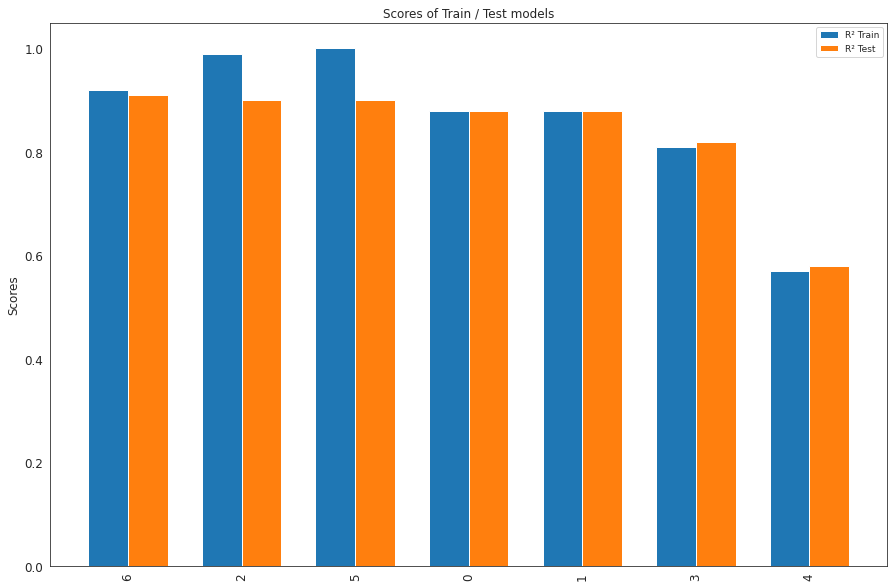

In [23]:
display_bar_plot(input_df=df)

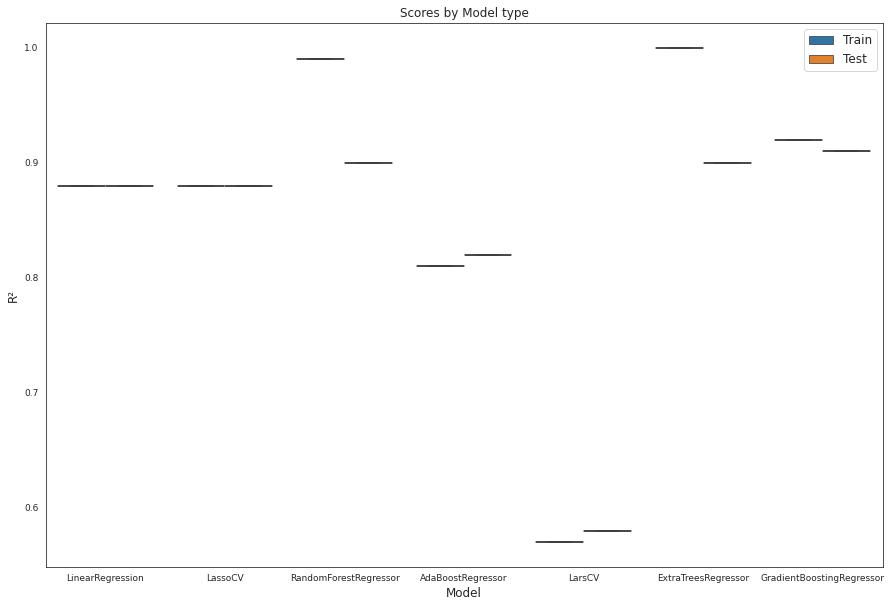

In [24]:
display_box_plots(input_df=df, method_attributes=["Model"])

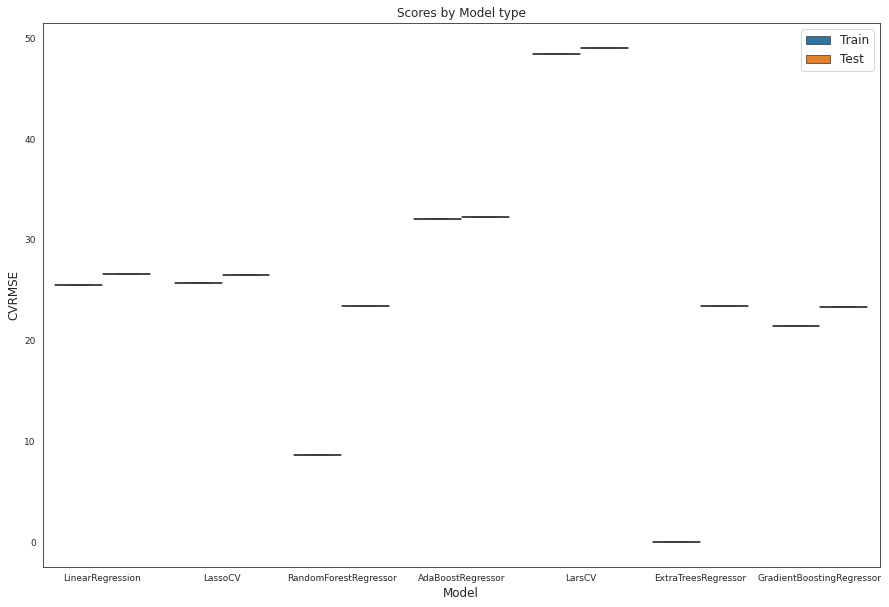

In [25]:
display_box_plots(input_df=df, metric_name="CVRMSE", method_attributes=["Model"])

Text(0, 0.5, 'Relative Production (MW/MW_installed)')

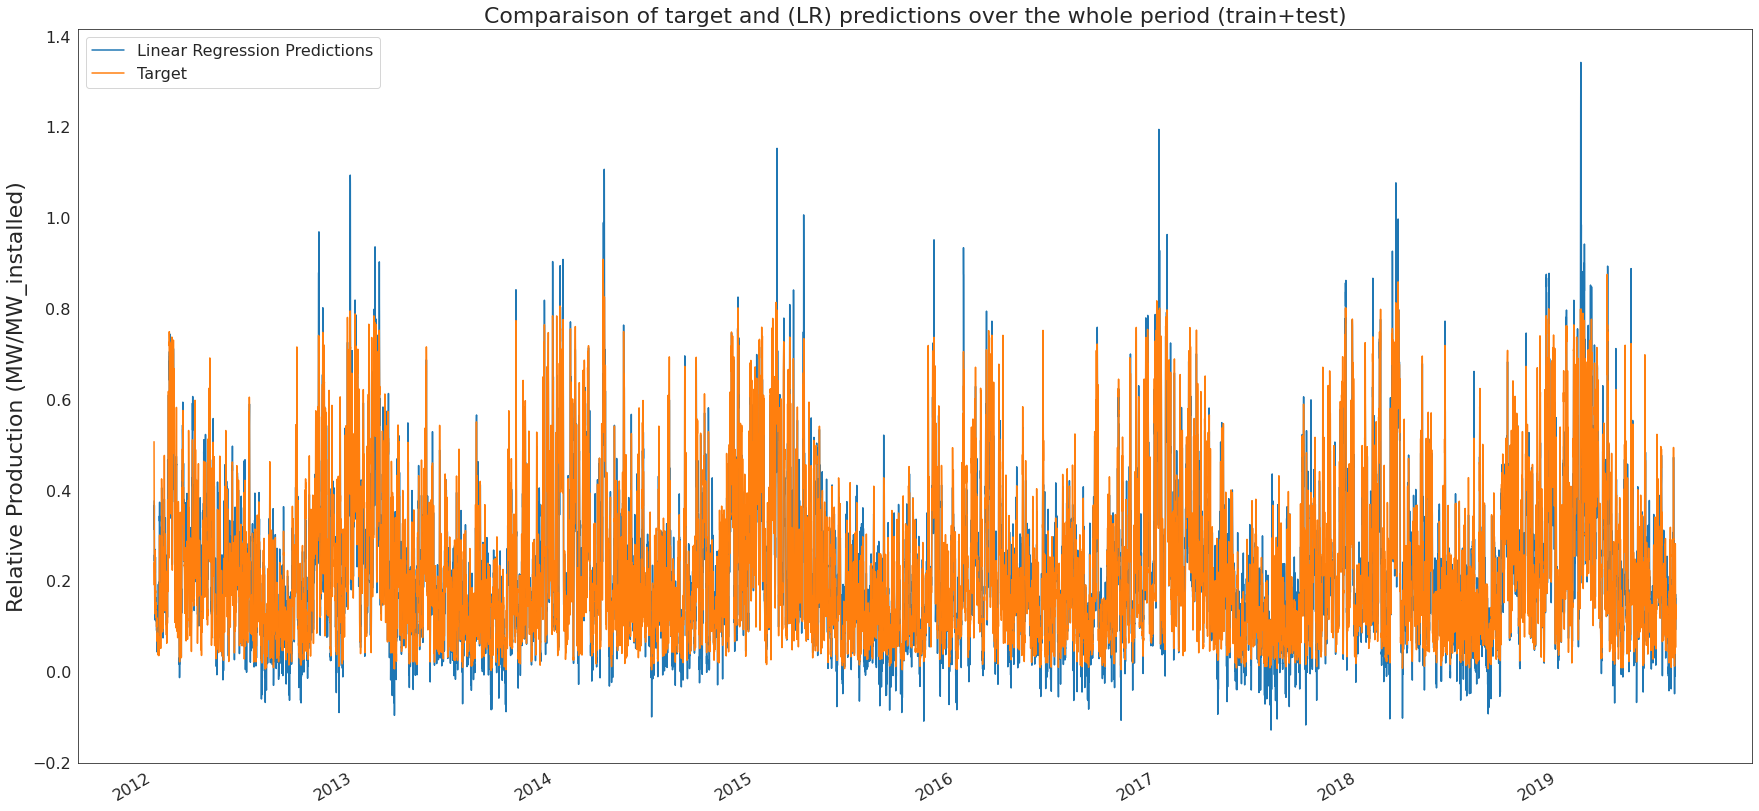

In [27]:
my_bench.experiments[0].predict(extended_data[cst.EXTENDED_FEATURES].dropna()).plot(
    label="Linear Regression Predictions"
)
data[cst.TARGET].plot(label="Target")
plt.legend()
plt.title(
    "Comparaison of target and (LR) predictions over the whole period (train+test)"
)
plt.ylabel("Relative Production (MW/MW_installed)")

In [29]:
corr = extended_data[cst.EXTENDED_FEATURES + [cst.TARGET]].corr()

<AxesSubplot:>

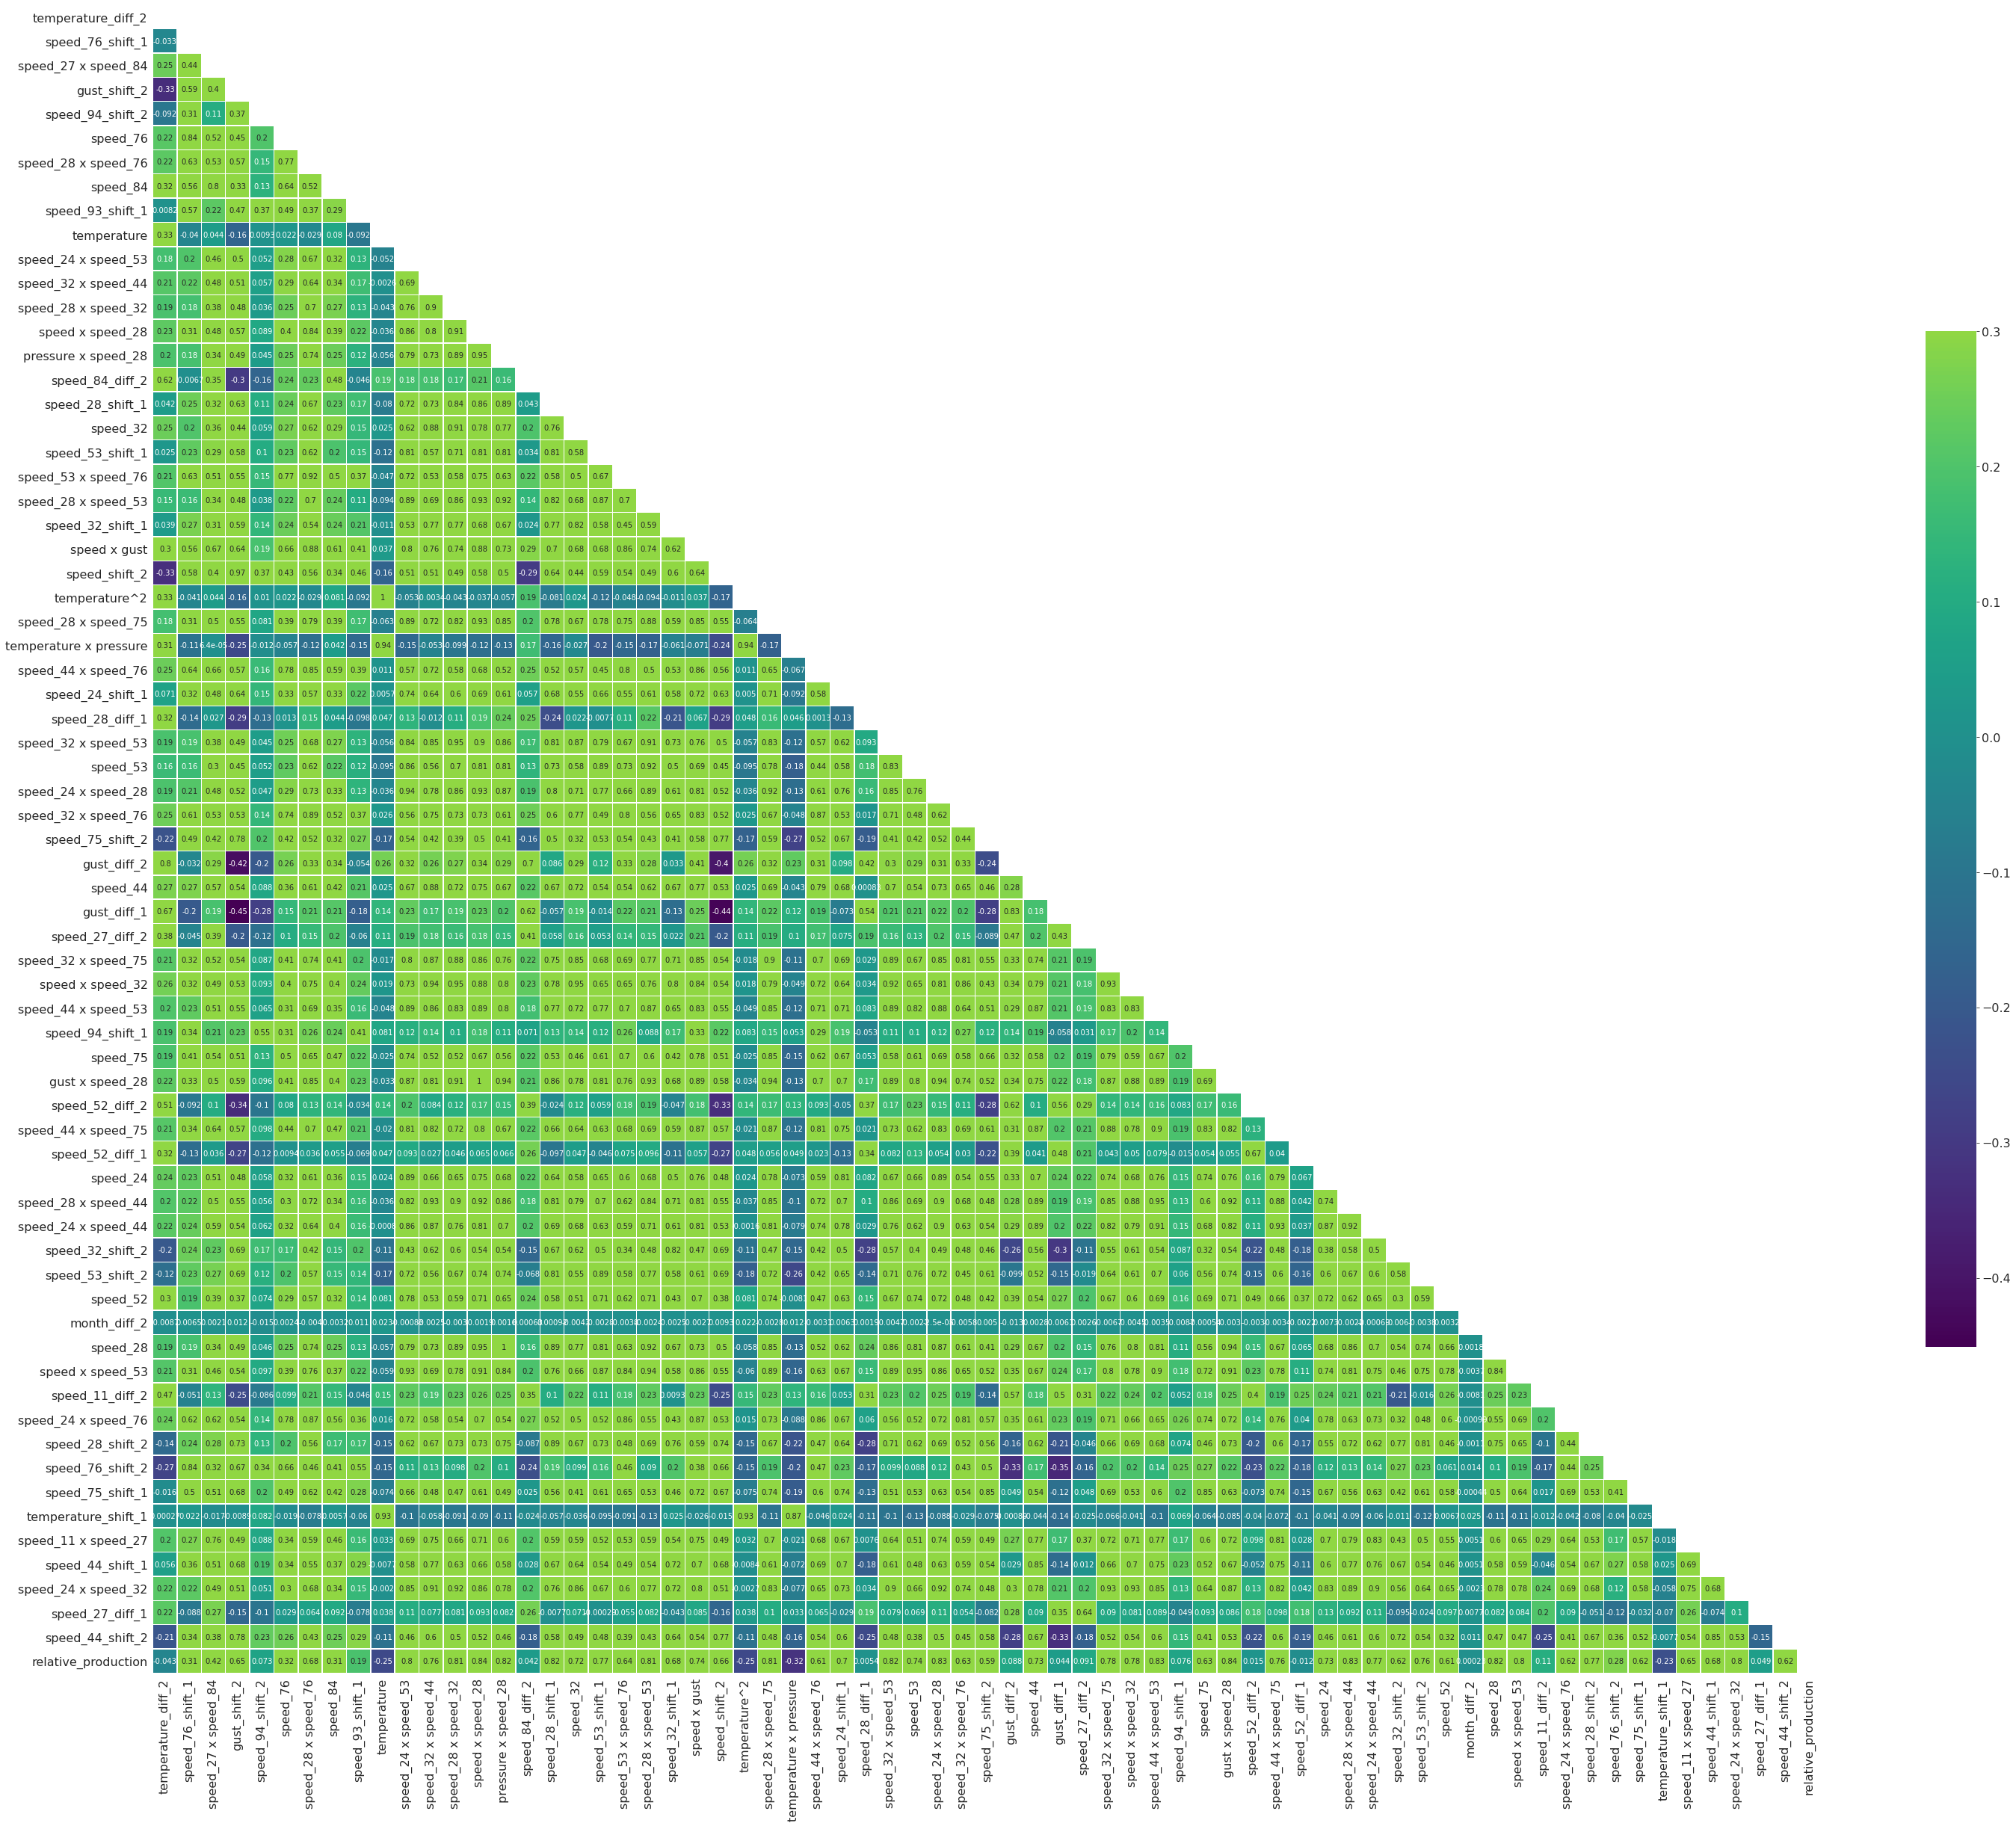

In [31]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    cmap="viridis",
)